## A.3: Final Report: SOTU

### Load Libraries

In [1]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import os
wd = os.getcwd()
wd_new = wd +'/nltk_data' #creating a new working directory path for stopwords files

import nltk
nltk.download('stopwords',download_dir=wd_new) 
nltk.download('wordnet',download_dir=wd_new)
nltk.data.path.append(wd_new)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

[nltk_data] Downloading package stopwords to /Users/mk1989f_a/Document
[nltk_data]     s/Mitch/Github/NU_453_NLP/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mk1989f_a/Documents/
[nltk_data]     Mitch/Github/NU_453_NLP/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Functionality to turn stemming on or off
STEMMING = False
NGRAM_LENGTH = 2

#### Pandas Parameters

In [3]:
#pandas parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Prep

### Function to process documents

In [5]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    file_stopwords = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/english",header=None)
    file_stopwords = file_stopwords[0].values.tolist()
    new_stopwords = ['effect','years','great','today','tonight','congress','freedom','united','states','united states'
                     ,'americans','america','american','americas','government','people','world','shall','would'
                     ,'nations','national','nation','country','state','public','policy'] #remove repeating terms
       
    new_stopwords= new_stopwords+file_stopwords
    stop_words = stop_words.union(new_stopwords)
    tokens = [w for w in tokens if not w in stop_words]        
    # word stemming    
    #if STEMMING:
        #ps=PorterStemmer()
        #tokens=[ps.stem(word) for word in tokens]
    # Lemmatization to account for things like plurals
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token) for token in tokens]
    
    return tokens

###   Functions to label encoding

In [6]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [7]:
# read data
data = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/sotu_corpus_small.csv")


In [8]:
# new data frame with split value columns 
new = data["DSI_Title"].str.split("_", n = 1, expand = True) 
  
# making separate President_Name column from new data frame 
data["President_Name"] = new[0] 
  
# making separate Year_SOTU column from new data frame 
data["Year_SOTU"] = new[1] 
  
new = data["Year_SOTU"].str.split(".", n = 1, expand = True) 
data["Year_SOTU"] = new[0] 

# df display 
data.shape
data.head(5) 

(102, 5)

,Unnamed: 0,DSI_Title,Text,President_Name,Year_SOTU
0,0,Reagan_1982.txt,"Mr. Speaker, Mr. President, distinguished Memb...",Reagan,1982
1,1,Wilson_1914.txt,GENTLEMEN OF THE CONGRESS: The session upon w...,Wilson,1914
2,2,Madison_1814.txt,Fellow-Citizens of the Senate and House of Rep...,Madison,1814
3,3,Johnson_1969.txt,"Mr. Speaker, Mr. President, Members of the Con...",Johnson,1969
4,4,Hoover_1930.txt,To the Senate and House of Representatives: I...,Hoover,1930


### Processing text into lists

In [ ]:
# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

In [ ]:
# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.

In [ ]:
# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

In [ ]:
# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

In [ ]:
# Length of full tokenized corpus
len(temp_text)

## Wordcloud

In [ ]:
pip install wordcloud

In [ ]:
# rerun stopwords to object
stop_words = set(stopwords.words('english'))
file_stopwords = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/english",header=None)
file_stopwords = file_stopwords[0].values.tolist()
new_stopwords = ['effect','years','great','today','tonight','congress','freedom','united','states','united states'
                     ,'americans','america','american','americas','government','people','world','shall','would'
                     ,'nations','national','nation','country','state','public','policy'] #remove repeating terms
       
new_stopwords= new_stopwords+file_stopwords
stop_words = stop_words.union(new_stopwords)

In [ ]:
# wordcloud
from wordcloud import WordCloud
long_string = ','.join(final_processed_text)
wordcloud = WordCloud(background_color="white",
                      width=1000, height=800,
                      stopwords=stop_words,
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### Sklearn TFIDF 
note the ngram_range will allow you to include multiple words within the TFIDF matrix

In [ ]:
# call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3), max_df=0.80, max_features=50000)


#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [ ]:
# Verify TFIDF_Matrix has been created.
matrix.shape
matrix.head()

In [ ]:
# Get unique names of President_Name to ensure BushW and BusHW were enetered correctly.
data['President_Name'].unique()

In [ ]:
# Simple plot to show the number of SOTU speeches by President Name

import seaborn as sns

plt.subplots(figsize=(19,5))
ax = sns.countplot(x="President_Name", data=data)
# plt.savefig("plot-president_name.pdf", bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, pad_inches=0.25)
plt.xlabel('President Name')
plt.ylabel('Count of SOTU')
plt.title('US: State of the Union Speeches (SOTU)')
plt.show()

### Explore Frequent Terms

In [ ]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
cv_matrix=cv.fit_transform(final_processed_text)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

In [ ]:
# Trying few things out (Ali) 

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(20, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(20, 'tf_corpus'))

### Explore TFIDF Values

In [ ]:
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

In [ ]:
outlier_list.shape

### Doc2Vec

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

### Gensim Word2vec 
Note, there are opportunities to use the word2vec matrix to determine words which are similar.  Similar words can be used to create equivalent classes.  
k-means is not used to group individual words using the Word2Vec output.

In [ ]:
#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

### K Means Clustering - TFIDF
the following section runs applies the k-means algorithm on the TFIDF matrix.

In [ ]:
number_clusters = range(1, 8)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(TFIDF_matrix).score(TFIDF_matrix) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [ ]:
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])


print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

### Plotting 
Convert two components as we're plotting points in a two-dimensional plane
"precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

In [ ]:
%matplotlib inline
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [ ]:
#fig.savefig('Images/clusters.png')

### Review Clusters

In [ ]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()

In [ ]:
# look at frequent terms across clusters
term_clusters

In [ ]:
titles = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
titles = titles.stack() #stack document names into 1 column
titles = titles.reset_index() #move index into a column
titles = titles.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
titles = titles.drop(['level_1'], axis=1) #drop unecessary column
titles.head()

In [ ]:
# join TFIDF values to documents in new dataframe w/ clusters
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = titles.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

In [ ]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [ ]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

In [ ]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(5,30))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

In [ ]:
p.get_figure().savefig('Images/heatmap_7.png')

# heatmap_1 using 8 clusters, no additional stopwords removed
# heatmap_2 using 8 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_3 using 6 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_4 using 6 clusters, reduced term size to 1-3 words, removed frequent words
# heatmap_5 using 6 clusters, reduced term size to 1-2 words, removed frequent words, increased top term size to 15 *BEST*
# heatmap_6 using 6 clsuters, reduced term size to 1-2 words, removed frequent words, increased top term size to 20
# heatmap_7 using 6 clsuters, term size to 1-3 words, removed frequent words, top term size 15

### LDA - topic modeling

In [ ]:
# Topic Modeling
# LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

ldamodel = LdaMulticore(corpus, num_topics=6, id2word=dictionary, passes=10, workers=3)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_text,id2word=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
pip install pyLDAvis

In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

In [ ]:
#LDA using TFIDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

##### Look at terms that show up in all documents

In [ ]:
matrix_copy = matrix.copy() #copy dataframe
matrix_copy = matrix_copy.T  #transpose

matrix_copy[(matrix_copy != 0).all(1)] # pull terms that show up in all documents


In [ ]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
cv_matrix=cv.fit_transform(final_processed_text)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

### Classification using various RF Model

The following section is used to create a model to predict the clusters labels based on the the TFIDF matrix and the doc2vec vectors.  

Note the model performance using the two different vectorization methods.

In [ ]:
model_RF=RandomForestClassifier()

#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=5)

#mean CV score
np.mean(cv_score)

#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X, Y, cv=5)

#mean CV score
np.mean(cv_score)

In [ ]:
# Trying few things out (Ali)

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(10, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(10, 'tf_corpus'))

## LSA

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

In [10]:
for col in data.columns: 
    print(col) 

Unnamed: 0
DSI_Title
Text
President_Name
Year_SOTU


In [11]:
data_sa = data

In [12]:
data_sa.drop(['Unnamed: 0', 'DSI_Title'], axis=1, inplace=True)

In [13]:
# Modify dataframe
data_sa['Year_SOTU'] = data_sa['Year_SOTU'].astype(int)
#df['President_Name'] = potus

#create a list of Democrat presidents
dems = ['Cleveland', 'Johnson', 'Wilson', 'Roosevelt', 'Truman', 'Kennedy', 'Carter', 'Obama']

#add party affiliation to the dataframe
data_sa['party'] = data_sa.President_Name.apply(lambda x: 'Democrat' if x in dems else 'Republican')

In [14]:
data_sa = data_sa[['Year_SOTU', 'President_Name', 'party', 'Text']]

In [15]:
data_sa.rename(columns={'Year_SOTU':'year', 'President_Name':'president', 'Text':'text'}, inplace=True)

In [16]:
data_sa.head()

,year,president,party,text
0,1982,Reagan,Republican,"Mr. Speaker, Mr. President, distinguished Memb..."
1,1914,Wilson,Democrat,GENTLEMEN OF THE CONGRESS: The session upon w...
2,1814,Madison,Republican,Fellow-Citizens of the Senate and House of Rep...
3,1969,Johnson,Democrat,"Mr. Speaker, Mr. President, Members of the Con..."
4,1930,Hoover,Republican,To the Senate and House of Representatives: I...


In [17]:
#use textblob to perform a sentiment analysis of each speech
data_sa['sentiment'] = data_sa['text'].apply(lambda speech: TextBlob(speech).sentiment.polarity)

Text(0.5, 20.80000000000002, 'Year')

Text(27.423986111111105, 0.5, 'Sentiment')

Text(0.5, 1, 'SotU Sentiment Analysis by President')

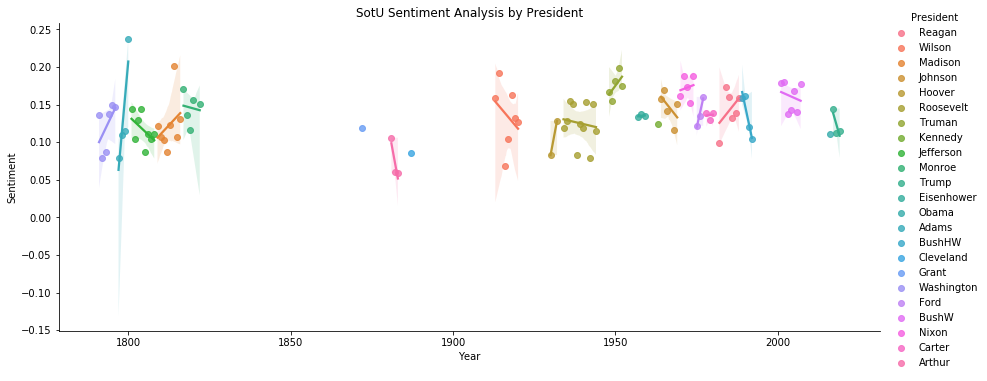

In [18]:
#plot sentiment analysis data
g = sns.lmplot(x="year", y="sentiment", hue="president", aspect=2.5, truncate=True, data=data_sa)
g._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('SotU Sentiment Analysis by President')

plt.show()

In [19]:
economic_df = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/gdp_data.csv")

In [20]:
data_sa = data_sa.merge(economic_df, how='left', on='year')

In [21]:
data_sa.rename(columns={'GDP Growth Rate':'gdp_rate'}, inplace=True)

In [22]:
data_sa = data_sa[data_sa['gdp_rate'].notna()].sort_values('year').reset_index(drop=True)
data_sa.head() 

,year,president,party,text,sentiment,gdp_rate
0,1930,Hoover,Republican,To the Senate and House of Representatives: I...,0.082816,-6.4
1,1932,Hoover,Republican,To the Senate and House of Representatives: I...,0.128491,-1.3
2,1934,Roosevelt,Democrat,"Mr. President, Mr. Speaker, Senators and Repre...",0.118513,8.9
3,1935,Roosevelt,Democrat,"Mr. President, Mr. Speaker, Members of the Sen...",0.128568,12.9
4,1936,Roosevelt,Democrat,"Mr. President, Mr. Speaker, Members of the Sen...",0.154848,5.1


Text(0.5, 20.80000000000002, 'Year')

Text(26.64301822916667, 0.5, '% GDP Growth Rate')

Text(0.5, 1, 'GDP Growth Rate by Year')

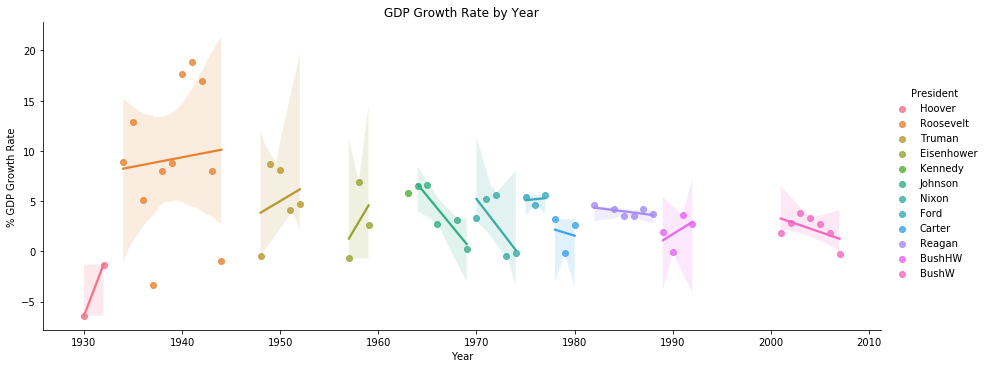

In [23]:
#plot GDP growth data
g1 = sns.lmplot(x="year", y="gdp_rate", hue="president", aspect=2.5, truncate=True, data=data_sa)
g1._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('% GDP Growth Rate')
plt.title('GDP Growth Rate by Year')

plt.show()

Text(0.5, 1.0, 'SotU Sentiment Analysis by President vs GDP Growth Rate')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'SoTu Sentiment Value')

Text(0, 0.5, '% GDP Growth Rate')

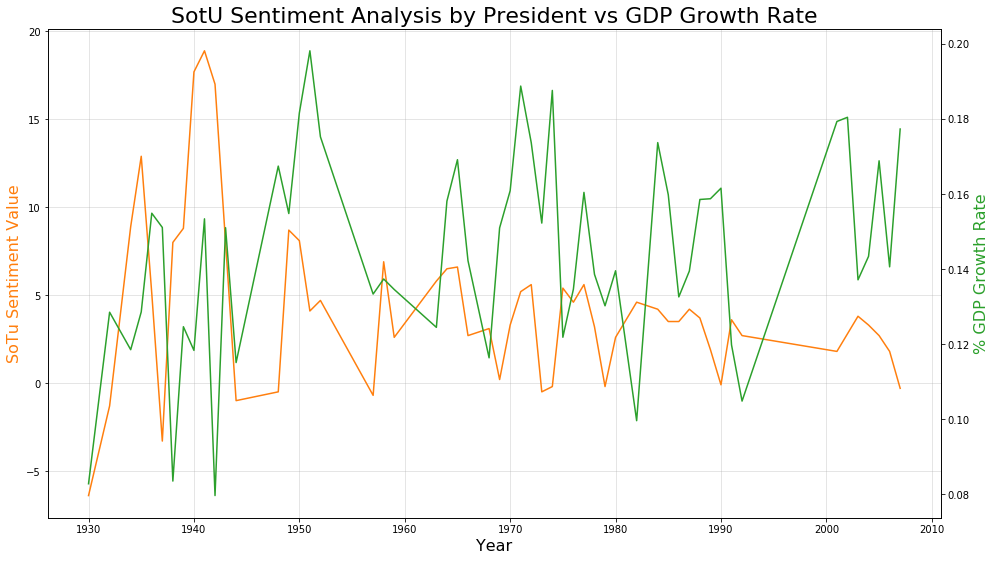

In [24]:
# Set black background
#plt.style.use("dark_background")

# Create combo chart
fig, ax1 = plt.subplots(figsize=(16,9))
# Plot 1 creation
ax1.set_title('SotU Sentiment Analysis by President vs GDP Growth Rate', fontsize=22)

ax2 = sns.lineplot(x='year', y='gdp_rate', data = data_sa, color='tab:orange')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('SoTu Sentiment Value', fontsize=16, color='tab:orange')
ax1.tick_params(axis='y')

ax1.grid(alpha=.4)

# Specify to share the same x-axis
ax2 = ax1.twinx()

# Plot 2 creation
ax2 = sns.lineplot(x='year', y='sentiment', data = data_sa, sort=False, color='tab:green')
ax2.set_ylabel('% GDP Growth Rate', fontsize=16, color='tab:green')
ax2.tick_params(axis='y')

#show plot
plt.show()

## Term Frequency by Decade


In [ ]:
# Create copy of Matrix 
matrix_decade = matrix
matrix_decade.index.name = ''
# matrix_decade.head(10)

# Rename Index
matrix_decade.index.name = "DSI_Title"

# Reset Index
matrix_decade = matrix_decade.reset_index()

In [ ]:
# Parse string to turn year of SOTU speech to a decade format
matrix_decade['DSI_Title'] = matrix_decade.DSI_Title.str.replace(r"[a-zA-Z._]",'')
matrix_decade['DSI_Title'] = matrix_decade['DSI_Title'].str.slice(0,3)
matrix_decade['DSI_Title'] = matrix_decade['DSI_Title'] + '0'

In [ ]:
# Group and sum the terms by decade of SOTU speech
matrix_decade_t = matrix_decade_t.groupby(axis=1, level=0).sum()
matrix_decade_t.head()

In [ ]:
# Create dataframe for each decade for further analysis

matrix_decade_1790 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1790'])
matrix_decade_1790 = matrix_decade_1790.loc[:, ['1790']]
matrix_decade_1790

matrix_decade_1800 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1800'])
matrix_decade_1800 = matrix_decade_1800.loc[:, ['1800']]
matrix_decade_1800

matrix_decade_1810 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1810'])
matrix_decade_1810 = matrix_decade_1810.loc[:, ['1810']]
matrix_decade_1810

matrix_decade_1820 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1820'])
matrix_decade_1820 = matrix_decade_1820.loc[:, ['1820']]
matrix_decade_1820

matrix_decade_1870 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1870'])
matrix_decade_1870 = matrix_decade_1870.loc[:, ['1870']]
matrix_decade_1870

matrix_decade_1880 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1880'])
matrix_decade_1880 = matrix_decade_1880.loc[:, ['1880']]
matrix_decade_1880

matrix_decade_1910 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1910'])
matrix_decade_1910 = matrix_decade_1910.loc[:, ['1910']]
matrix_decade_1910

matrix_decade_1920 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1920'])
matrix_decade_1920 = matrix_decade_1920.loc[:, ['1920']]
matrix_decade_1920

matrix_decade_1930 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1930'])
matrix_decade_1930 = matrix_decade_1930.loc[:, ['1930']]
matrix_decade_1930

matrix_decade_1940 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1940'])
matrix_decade_1940 = matrix_decade_1940.loc[:, ['1940']]
matrix_decade_1940

matrix_decade_1950 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1950'])
matrix_decade_1950 = matrix_decade_1950.loc[:, ['1950']]
matrix_decade_1950

matrix_decade_1960 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1960'])
matrix_decade_1960 = matrix_decade_1960.loc[:, ['1960']]
matrix_decade_1960

matrix_decade_1970 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1970'])
matrix_decade_1970 = matrix_decade_1970.loc[:, ['1970']]
matrix_decade_1970

matrix_decade_1980 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1980'])
matrix_decade_1980 = matrix_decade_1980.loc[:, ['1980']]
matrix_decade_1980

matrix_decade_1990 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1990'])
matrix_decade_1990 = matrix_decade_1990.loc[:, ['1990']]
matrix_decade_1990

matrix_decade_2000 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['2000'])
matrix_decade_2000 = matrix_decade_2000.loc[:, ['2000']]
matrix_decade_2000

matrix_decade_2010 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['2010'])
matrix_decade_2010 = matrix_decade_2010.loc[:, ['2010']]
matrix_decade_2010

In [ ]:
# Merge dataframes into one table to show overlaps between decades
matrix_decade_merge = pd.concat([matrix_decade_1790, matrix_decade_1800, matrix_decade_1810, matrix_decade_1820, matrix_decade_1870, matrix_decade_1880, matrix_decade_1910, matrix_decade_1920, matrix_decade_1930, matrix_decade_1940, matrix_decade_1950, matrix_decade_1960, matrix_decade_1970, matrix_decade_1980, matrix_decade_1990, matrix_decade_2000, matrix_decade_2010], axis=1, sort=False)

# Replace NaN values with 0
matrix_decade_merge = matrix_decade_merge.replace(np.nan,0)

# Round numbers to 3 decimal places
matrix_decade_merge = matrix_decade_merge.round(decimals=3)

In [ ]:
matrix_decade_merge

In [ ]:
clrs = ['grey' if (x < max(matrix_decade_1790['1790'])) else 'red' for x in matrix_decade_1790['1790']]
sns.barplot(data = matrix_decade_1790.reset_index(), x='index',y='1790', palette=clrs)

In [ ]:
matrix_decade_1790.reset_index().plot(kind='barh', x='index', y='1790')